# Recurrent Neural Networks

**Recurrent Neural Network** introduced cycles and notion of time.  
![rnn](rnn.png)

We can unroll the RNN as follows:

![unrolled_rnn](unrolled_rnn.png)

### How to compute the forward and backward propogation for recurrent neural network?

For every timestep $t$, $h_t$ and $y_t$ is computed with the following formulas:

$$h_t = \text{tanh}(W_{hh}h_{t-1} + W_{xh}x_t)$$

$$y_t = W_{hy}h_t$$

Note same function and same parameter is used at every timestep.  Moreoever, we need to across time before calculating higher level parameters.


# Types of Recurrent Neural Networks

## Data Input

Recall for non-recurrent neural network, the dimension of data input is $x \in \mathbb{R}^{N, M}$ where $N$ is number of data points and $M$ is number of features.  

For recurrent neural network, we will add an additional dimension $T$, which represents the *timestamp*.  

In [1]:
# (Example network for image captioning in tensorboard)
from coco_input import *
import matplotlib.pyplot as plt
import PIL
data_dir = '/home/karen/workspace/data/cocodataset/'
coco_data = CocoCaptionData(data_dir)


In [2]:
caption_data, features = coco_data.sample_data()

In [5]:
def get_vocab(caption_data):
    vocab_data = set()
    for c in caption_data:
        for v in c.split(" "):
            vocab_data.add(v)
    return list(vocab_data)

In [6]:
randint = np.random.randint(len(features))
image_id = caption_data["image_id"][randint]
caption = caption_data["caption"][randint]
sample_image_id = features
# img_url = features[sample_image_id]
filename = sample_image_id[image_id]
# d = coco_data.dict_data


(640, 474)


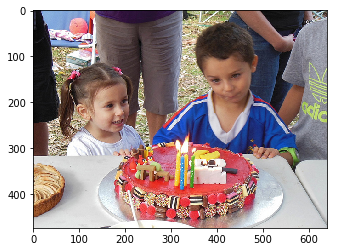

Two children are standing near a birthday cake.


In [7]:
im = PIL.Image.open(filename)
plt.imshow(im)
print(im.size)
plt.show()
print(caption)

In [8]:
input_fn = coco_data.coco_input(data_dir, True, False, False, 1, 500, 64)

In [8]:
print(input_fn())

({'filename': <tf.Tensor 'IteratorGetNext:1' shape=(64,) dtype=string>, 'caption_id': <tf.Tensor 'IteratorGetNext:0' shape=(64, 2) dtype=int64>, 'img': <tf.Tensor 'IteratorGetNext:2' shape=(64, 224, 224, 3) dtype=float32>}, <tf.Tensor 'IteratorGetNext:3' shape=(64, 180) dtype=float64>)


### Sample Models with RNN

![onetomany](12many.png)

**Image captioning**: image captioning would require one input and output frome many recurrent cells.

In [56]:
def conv_model(inputs):
    inputs =  tf.layers.conv2d(inputs, 32, 7)
    return tf.layers.flatten(inputs)

def rnn_model(output_length, state_size=128):
    middle_level_cell = tf.contrib.rnn.BasicRNNCell(num_units=output_length)
    
    init = middle_level_cell.zero_state(BATCH_SIZE, dtype=tf.float32)

    output_level_cell = tf.contrib.rnn.BasicRNNCell(num_units=output_length)
    stacked_rnn = tf.contrib.rnn.MultiRNNCell([middle_level_cell, output_level_cell])
    return stacked_rnn

def model(inputs):
    initial_state = conv_model(inputs)
    

In [57]:
word_to_id = get_vocab(caption_data["caption"])
word_map = {v:i for i,v in enumerate(word_to_id)}
VOCAB_SIZE = len(word_to_id)

In [61]:

EMBEDDING_SIZE = 32
def model_fn(features, labels, mode, params):
    inputs = features["img"]
    embeddings = tf.Variable(tf.random_uniform([VOCAB_SIZE, EMBEDDING_SIZE], -1.0, 1.0))
    labels = tf.cast(labels, dtype=tf.int64)
    caption_embedding = tf.nn.embedding_lookup(embeddings, labels)
    initial_state = conv_model(inputs)
    print(initial_state.shape)
    rnn = rnn_model(initial_state.shape[1])
    N, T, E = caption_embedding.shape
    state = initial_state
    for i in range(T):
        outputs, state = rnn(caption_embedding[:,i,:], state)
    
    


In [62]:
# hardware configuration
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
run_config = tf.estimator.RunConfig(session_config=config)

# Definition of Estimators
classifier = tf.estimator.Estimator(model_fn=model_fn, 
                                    model_dir="tmp/test_model", 
                                    config=run_config,
                                    params=None)

INFO:tensorflow:Using config: {'_model_dir': 'tmp/test_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  allow_growth: true
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc4472d8978>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [63]:
classifier.train(input_fn, max_steps=1)

INFO:tensorflow:Calling model_fn.
(64, 1520768)
(64, 1520768)


ValueError: Expected state to be a tuple of length 2, but received: Tensor("flatten/Reshape:0", shape=(64, 1520768), dtype=float32)

# Problems with RNN